In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


下載資料集

In [3]:
!mkdir ./train
!cp "/content/drive/MyDrive/Colab Notebooks/train.zip" /content/train.zip
!cd train&&unzip /content/train.zip

Archive:  /content/train.zip
   creating: images/
  inflating: images/image_0608.jpg   
  inflating: images/image_0620.jpg   
  inflating: images/image_0387.png   
  inflating: images/image_0634.jpg   
  inflating: images/image_0378.png   
  inflating: images/image_0436.png   
  inflating: images/image_0350.png   
  inflating: images/image_0185.jpg   
  inflating: images/image_0191.jpg   
  inflating: images/image_0344.png   
  inflating: images/image_0422.png   
  inflating: images/image_0813.png   
  inflating: images/image_0807.png   
  inflating: images/image_0152.png   
  inflating: images/image_0146.png   
  inflating: images/image_0393.JPG   
  inflating: images/image_0967.png   
  inflating: images/image_0973.png   
  inflating: images/image_0218.jpg   
  inflating: images/image_0556.jpg   
  inflating: images/image_0783.png   
  inflating: images/image_0797.png   
  inflating: images/image_0542.jpg   
  inflating: images/image_0224.jpg   
  inflating: images/image_0768.png   


In [4]:
import os, cv2, random
from sklearn.utils import shuffle
import numpy as np
import gc
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import tensorflow as tf
import torch

讀取資料集

In [5]:
import numpy as np
from keras.preprocessing import image

dataset = tf.keras.preprocessing.image_dataset_from_directory(
                '/content/train/images',
                batch_size = None,
                label_mode = None,
                image_size = (299, 299),
                shuffle = False)

Found 1000 files belonging to 1 classes.


In [6]:
labels = pd.read_csv('/content/train/annotation.csv')
labels = labels.iloc[:,1:].to_numpy()

資料標準化

In [7]:
images = []
for a in dataset:
     images.append(np.array(a))
images = np.array(images)/255.

print('image shape',images.shape)
print('label shape',labels.shape)

image shape (1000, 299, 299, 3)
label shape (1000, 4)


分割訓練與測試集

In [8]:
x_train, x_test, y_train, y_test=train_test_split(images,labels, test_size=0.3, shuffle=True)

# Pytorch

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16
learning_rate = 0.0002
epoch = 100

轉換為Pytorch Tensor格式

In [133]:
tensor_x_train = torch.Tensor(x_train.transpose(0, 3, 1, 2)) # H*W*C to C*H*W
tensor_y_train = torch.Tensor(y_train)
train_datasets  = TensorDataset(tensor_x_train,tensor_y_train) 
train_dataloader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True) 

tensor_x_test = torch.Tensor(x_test.transpose(0, 3, 1, 2)) 
tensor_y_test = torch.Tensor(y_test)
test_datasets  = TensorDataset(tensor_x_test,tensor_y_test)
test_dataloader = DataLoader(test_datasets, batch_size=batch_size, shuffle=True) 

建構網路 ResNet

In [134]:
class ResNet(nn.Module):
    def __init__(self, num_classes=4):	   
        super(ResNet, self).__init__()
        self.model_resnet = models.resnet18(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model_resnet(x)
        out = self.fc(x)   
        return out

In [135]:
model = ResNet()
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters())
loss_func = nn.MSELoss()

模型訓練

In [136]:
history ={'train_loss':[],'test_loss':[]}
for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    test_loss = 0.
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss
   
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for img, label in test_dataloader:
              img = Variable(img).cuda()
              label = Variable(label).cuda()
              output = model(img)
              loss = loss_func(output, label)
              test_loss += loss
    Train_loss = float(train_loss / (len(train_datasets)))
    Test_loss = float(test_loss / (len(test_datasets)))
    history['train_loss'].append(Train_loss)
    history['test_loss'].append(Test_loss)

    print("Train Loss:%.9f" % Train_loss)
    print("Test Loss:%.9f" % Test_loss)

epoch 1
Train Loss:2379.884765625
Test Loss:2112.548828125
epoch 2
Train Loss:1842.725219727
Test Loss:1577.826171875
epoch 3
Train Loss:1347.054321289
Test Loss:1119.480590820
epoch 4
Train Loss:928.330627441
Test Loss:741.593322754
epoch 5
Train Loss:593.734375000
Test Loss:451.518341064
epoch 6
Train Loss:345.814514160
Test Loss:246.218673706
epoch 7
Train Loss:179.663467407
Test Loss:118.111412048
epoch 8
Train Loss:77.425659180
Test Loss:38.607501984
epoch 9
Train Loss:24.286712646
Test Loss:13.310039520
epoch 10
Train Loss:10.127871513
Test Loss:6.761248112
epoch 11
Train Loss:6.603415012
Test Loss:5.425261497
epoch 12
Train Loss:4.720776081
Test Loss:4.082118511
epoch 13
Train Loss:3.779805422
Test Loss:3.547059774
epoch 14
Train Loss:3.081915379
Test Loss:3.043467283
epoch 15
Train Loss:2.696862936
Test Loss:3.153062344
epoch 16
Train Loss:2.635744333
Test Loss:3.148567677
epoch 17
Train Loss:2.500668287
Test Loss:3.006050348
epoch 18
Train Loss:2.515122652
Test Loss:2.96855330

LOSS紀錄

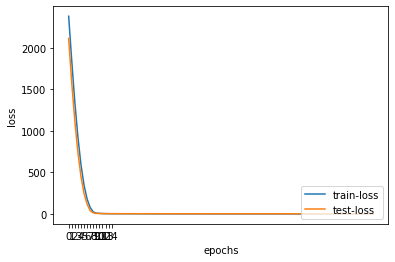

In [137]:
plt.plot(history['train_loss'],label='train-loss')
plt.plot(history['test_loss'],label='test-loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks([epoch for epoch in range(15)])
plt.legend(loc='lower right')

預測

In [138]:
imgs, labels = next(iter(test_dataloader))
imgs = Variable(imgs).cuda()
labels = Variable(labels).cuda()
with torch.no_grad():
  outputs = model(imgs)
imgs = imgs.cpu().numpy()
imgs = imgs.transpose(0, 2, 3, 1)
labels = Variable(labels).cpu().numpy()
outputs = Variable(outputs).cpu().numpy()
imgs.shape

(16, 299, 299, 3)

In [143]:
outputs[0]

array([ 53.124954, 123.108406,  81.11635 , 384.15112 ], dtype=float32)

In [144]:
labels[0]

array([ 52., 131.,  77., 385.], dtype=float32)

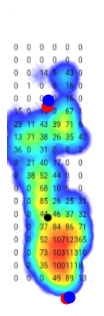

In [154]:
import cv2
import matplotlib 

dpi = matplotlib.rcParams['figure.dpi']
show_img = cv2.resize(imgs[0],(120,400))

height, width, depth = show_img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')

plt.scatter(labels[0][0], labels[0][1], c='r', s=120)
plt.scatter(labels[0][2], labels[0][3], c='r', s=120)

plt.scatter(outputs[0][0], outputs[0][1], c='b', s=120)
plt.scatter(outputs[0][2], outputs[0][3], c='b', s=120)
plt.imshow(show_img)
plt.savefig('predict.png', bbox_inches='tight')

In [155]:
torch.save(model, 'model.pt')